In [1]:
import sys
import time
import warnings
from tqdm import tqdm
from math import log
#data processing
import pandas as pd
import numpy as np

#visualisation
import matplotlib.pyplot as plt 
import seaborn as sns

from scipy.stats import kruskal, pearsonr, ttest_ind
from sklearn import preprocessing
from collections import Counter
# Metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import log_loss, classification_report, confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import ShuffleSplit

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree


from logic.feature_extraction import FeatureExtraction
from logic.text_analysis import TextAnalysis
from root import DIR_INPUT

In [2]:
lang = 'es'

In [3]:
ftrain = '{0}{1}{2}{3}'.format(DIR_INPUT, 'Valence_train_oc_', lang, '.csv')
ftest = '{0}{1}{2}{3}'.format(DIR_INPUT, 'Valence_test_oc_', lang, '.csv')

In [4]:
ta = TextAnalysis(lang=lang)

Language: es
Text Analysis: ['tok2vec', 'morphologizer', 'emoji', 'syllables', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [5]:
features = FeatureExtraction(lang=lang, text_analysis=ta)

In [6]:
train_data = pd.read_csv(ftrain, sep = ';')

In [7]:
train_data['clean_text'] = train_data['Tweet'].apply(lambda x: ta.clean_text(x))
train_data

,ID,Tweet,Dimension,Intensity,Description,clean_text
0,2018-Es-00818,Este año me tocará ir sola a la Convención de ...,valence,0,se infiere un estado emocional neutral or mixto,este año me tocará ir sola a la convención de ...
1,2018-Es-06065,MB si no me equivoco una vez me confundi de sn...,valence,0,se infiere un estado emocional neutral or mixto,mb si no me equivoco una vez me confundi de sn...
2,2018-Es-00417,@cokep Que eres terrible fome! 🙄 Y añejo poh!,valence,-2,se infiere un estado emocional moderadamente n...,MENCION que eres terrible fome fastidio y añej...
3,2018-Es-00861,Gracias por informar temas de contingencia del...,valence,-1,se infiere un estado emocional ligeramente neg...,gracias por informar temas de contingencia del...
4,2018-Es-01772,En Maipú hace falta una peluquería ATR,valence,-1,se infiere un estado emocional ligeramente neg...,en maipú hace falta una peluquería atr
...,...,...,...,...,...,...
1561,2018-Es-01295,Sale uno del estadio como todo preocupado.,valence,-1,se infiere un estado emocional ligeramente neg...,sale uno del estadio como todo preocupado
1562,2018-Es-04833,"No mames, qué fino.",valence,0,se infiere un estado emocional neutral or mixto,no mames qué fino
1563,2018-Es-05750,"Me bajo mucho en la hermana del raton, pero e...",valence,-1,se infiere un estado emocional ligeramente neg...,me bajo mucho en la hermana del raton pero es ...
1564,2018-Es-00894,"@vito_cfc @SSFE2017 Jjaakjak , pronto lo haré",valence,1,se infiere un estado emocional ligeramente pos...,MENCION cfc MENCION jjaakjak pronto lo haré


In [8]:
train = train_data.drop(['ID', 'Tweet', 'Dimension', 'Description'], axis = 1)

In [9]:
train['Intensity'] = train['Intensity'].replace([-2, -3], -1)
train['Intensity'] = train['Intensity'].replace([2, 3], 1)

In [10]:
train

,Intensity,clean_text
0,0,este año me tocará ir sola a la convención de ...
1,0,mb si no me equivoco una vez me confundi de sn...
2,-1,MENCION que eres terrible fome fastidio y añej...
3,-1,gracias por informar temas de contingencia del...
4,-1,en maipú hace falta una peluquería atr
...,...,...
1561,-1,sale uno del estadio como todo preocupado
1562,0,no mames qué fino
1563,-1,me bajo mucho en la hermana del raton pero es ...
1564,1,MENCION cfc MENCION jjaakjak pronto lo haré


# Test

In [11]:
test_data = pd.read_csv(ftest, sep = ';')

In [12]:
test_data['clean_text'] = test_data['Tweet'].apply(lambda x: ta.clean_text(x))
test_data

,ID,Tweet,Dimension,Intensity,Description,clean_text
0,2018-Es-00766,Dios que susto lpmmm 🙏😡,valence,-2,se infiere un estado emocional moderadamente n...,dios que susto lpmmm por favor enojado
1,2018-Es-01333,Que lindo que es viajar en moto vieja,valence,2,se infiere un estado emocional moderadamente p...,que lindo que es viajar en moto vieja
2,2018-Es-06190,que ansiedad de mierda vo,valence,-3,se infiere un estado emocional muy negativo,que ansiedad de mierda vo
3,2018-Es-05144,La ansiedad no desaprovecha ni un segundo.,valence,-2,se infiere un estado emocional moderadamente n...,la ansiedad no desaprovecha ni un segundo
4,2018-Es-04187,@ts8rr8t Mucho gusto.,valence,2,se infiere un estado emocional moderadamente p...,MENCION mucho gusto
...,...,...,...,...,...,...
224,2018-Es-02893,Ustedes que saben de terror si sus hij@s no le...,valence,-1,se infiere un estado emocional ligeramente neg...,ustedes que saben de terror si sus hij MENCION...
225,2018-Es-03654,@AmorVIPcom Un gusto..,valence,1,se infiere un estado emocional ligeramente pos...,MENCION un gusto
226,2018-Es-01556,@elespanolcom A lo loco!!! ¿Lo próximo qué ser...,valence,-3,se infiere un estado emocional muy negativo,MENCION a lo loco lo próximo qué será que pued...
227,2018-Es-06385,@the_os_07 @globovision tiburón eres un enchuf...,valence,-2,se infiere un estado emocional moderadamente n...,MENCION os MENCION tiburón eres un enchufado m...


In [13]:
test = test_data.drop(['ID', 'Tweet', 'Dimension', 'Description'], axis = 1)

In [14]:
test['Intensity'] = test['Intensity'].replace([-2, -3], -1)
test['Intensity'] = test['Intensity'].replace([2, 3], 1)
test

,Intensity,clean_text
0,-1,dios que susto lpmmm por favor enojado
1,1,que lindo que es viajar en moto vieja
2,-1,que ansiedad de mierda vo
3,-1,la ansiedad no desaprovecha ni un segundo
4,1,MENCION mucho gusto
...,...,...
224,-1,ustedes que saben de terror si sus hij MENCION...
225,1,MENCION un gusto
226,-1,MENCION a lo loco lo próximo qué será que pued...
227,-1,MENCION os MENCION tiburón eres un enchufado m...


In [15]:
x_train = train['clean_text']
y_train = train['Intensity']

In [16]:
x_test = test['clean_text']
y_test = test['Intensity']

## Get training features

In [17]:
x_train = features.get_feature_phonestheme(x_train)

100%|██████████| 1566/1566 [00:52<00:00, 29.63it/s]


In [18]:
x_train = preprocessing.normalize(x_train)

## Get test features

In [19]:
x_test = features.get_feature_phonestheme(x_test)
x_test = preprocessing.normalize(x_test)

100%|██████████| 229/229 [00:07<00:00, 31.13it/s]


## Over sampling

In [20]:
print('**Sample train:', sorted(Counter(y_train).items()))
print('**Sample test:', sorted(Counter(y_test).items()))

**Sample train: [(-1, 779), (0, 354), (1, 433)]
**Sample test: [(-1, 107), (0, 48), (1, 74)]


In [21]:
ros_train = RandomUnderSampler(random_state=1000)
x_train, y_train = ros_train.fit_resample(x_train, y_train)
print('**OverSampler train:', sorted(Counter(y_train).items()))

**OverSampler train: [(-1, 354), (0, 354), (1, 354)]


In [22]:
ros_test = RandomOverSampler(random_state=1000)
x_test, y_test = ros_test.fit_resample(x_test, y_test)
print('**RandomOverSampler test:', sorted(Counter(y_test).items()))

**RandomOverSampler test: [(-1, 107), (0, 107), (1, 107)]


In [23]:
k_fold = ShuffleSplit(n_splits=10, test_size=0.30, random_state=42)

In [24]:
models = [("RF", RandomForestClassifier(max_depth=200, n_estimators=200, random_state=42)),
          ("DT", DecisionTreeClassifier(max_depth = 4)),
          ("NB", GaussianNB())]

In [25]:
finalResults = []
cmList = []
for name, model in models:
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    for train_index, test_index in k_fold.split(x_train, y_train):
        data_train = x_train[train_index]
        target_train = y_train[train_index]

        data_test = x_train[test_index]
        target_test = y_train[test_index]
        
        model.fit(data_train, target_train)
        predict = model.predict(data_test)
         # Accuracy
        accuracy = accuracy_score(target_test, predict, normalize=True)
        accuracies.append(accuracy)
        # Precision
        precision = precision_score(target_test, predict, average="macro")
        precisions.append(precision)
        # recall
        recall = recall_score(target_test, predict, average="macro")
        recalls.append(recall)
        # f1
        f1 = f1_score(target_test, predict, average="macro")
        f1s.append(f1)
    
    y_predict = model.predict(x_test)
    cm= confusion_matrix(y_test, y_predict)
    cmList.append((name,cm))
    
    finalResults.append({'name':name, 
                         'model': model,
                         'accuracy': round(np.mean(accuracies), 2), 
                         'precision': round(np.mean(precisions), 2),
                         'recall': round(np.mean(recalls), 2),
                         'f1': round(np.mean(f1s), 2),
                         'confusion_matrix': cm
                        })

In [26]:
df_result = pd.DataFrame.from_dict(finalResults)
df_result

,name,model,accuracy,precision,recall,f1,confusion_matrix
0,RF,"(DecisionTreeClassifier(max_depth=200, max_fea...",0.42,0.42,0.42,0.42,"[[52, 31, 24], [37, 45, 25], [31, 30, 46]]"
1,DT,DecisionTreeClassifier(max_depth=4),0.36,0.36,0.36,0.35,"[[42, 22, 43], [30, 20, 57], [26, 18, 63]]"
2,NB,GaussianNB(),0.40,0.42,0.40,0.38,"[[66, 27, 14], [40, 39, 28], [51, 25, 31]]"


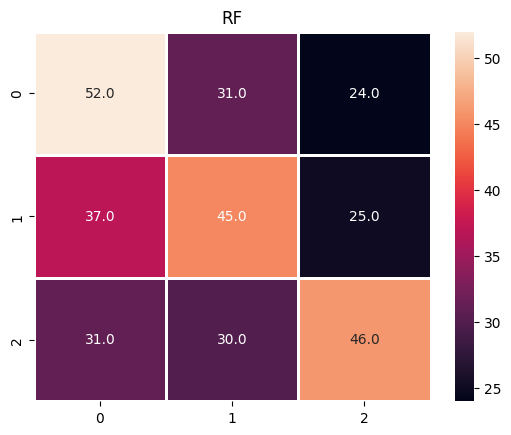

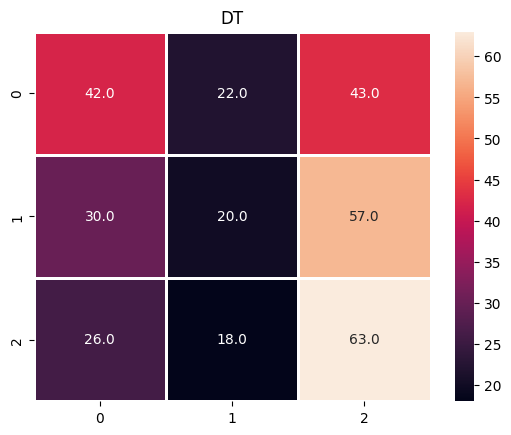

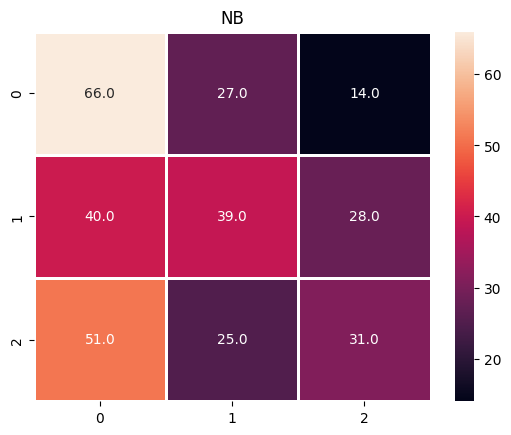

In [27]:
for name , i in cmList:
    plt.figure()
    sns.heatmap(i , annot =True, linewidth=0.8,fmt=".1f")
    plt.title(name)
    plt.show()